
# Proyecto 5 — Chatbot Conversacional Multimodal para Servicio al Cliente (Banco Digital)

**Problema:** Alto volumen de consultas repetitivas (~80%) y necesidad de atención 24/7.  
**Solución:** Chatbot inteligente con **NLU (BERT + clasificación de intenciones + extracción de entidades)**, **gestión de diálogo basada en Transformer con memoria**, **pipeline multimodal (texto + OCR de imágenes)**, **API + interfaz web (Gradio)** y **sistema de evaluación**.

**Datasets:** [Banking77](https://huggingface.co/datasets/banking77)

> Este notebook está estructurado para ejecutarse en **Google Colab**.


## 1. Instalación y configuración

In [ ]:

# Recomendado ejecutar en Google Colab
!pip -q install --upgrade pip
!pip -q install transformers datasets accelerate evaluate scikit-learn gradio fastapi uvicorn pyngrok python-multipart pillow pytesseract matplotlib
# Opcional: spaCy y modelo liviano en inglés para entidades
!pip -q install spacy && python -m spacy download en_core_web_sm
# Para mostrar gráficas
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.4 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Carga del dataset Banking77 (intenciones bancarias)

In [ ]:

from datasets import load_dataset

ds = load_dataset("banking77")
label_list = ds["train"].features["label"].names
num_labels = len(label_list)
print("Clases:", num_labels)
print("Ejemplo:", ds["train"][0])


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Clases: 77
Ejemplo: {'text': 'I am still waiting on my card?', 'label': 11}


## 3. Preparación de datos (train/validation/test)

In [ ]:

from datasets import DatasetDict

# Banking77 ya trae split train/test; creamos validación a partir de train
train_test_valid = ds
train_valid = train_test_valid["train"].train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({
    "train": train_valid["train"],
    "validation": train_valid["test"],
    "test": train_test_valid["test"]
})
for k in dataset:
    print(k, len(dataset[k]))


train 9002
validation 1001
test 3080


## 4. Baseline: Embeddings básicos (TF‑IDF) + Clasificación Multiclase (LogisticRegression)

In [ ]:

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd

# Convertimos a DataFrame para facilidad
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
val_texts = dataset["validation"]["text"]
val_labels = dataset["validation"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=40000)
X_train = tfidf.fit_transform(train_texts)
X_val = tfidf.transform(val_texts)
X_test = tfidf.transform(test_texts)

clf = LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto")
clf.fit(X_train, train_labels)
val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

print("Baseline (TF‑IDF + LR)")
print("Valid Accuracy:", accuracy_score(val_labels, val_pred))
print("Valid Macro-F1:", f1_score(val_labels, val_pred, average="macro"))
print("Test  Accuracy:", accuracy_score(test_labels, test_pred))
print("Test  Macro-F1:", f1_score(test_labels, test_pred, average="macro"))

# Matriz de confusión (conjunto de prueba)
cm = confusion_matrix(test_labels, test_pred, labels=list(range(num_labels)))
cm_df = pd.DataFrame(cm, index=label_list, columns=label_list)
print("Matriz de confusión (test) -> usando las 77 etiquetas (se muestra shape):", cm_df.shape)

# Mostrar top‑5 intenciones del baseline (por probabilidad) para una consulta ejemplo
def baseline_topk(query, k=5):
    probs = clf.predict_proba(tfidf.transform([query]))[0]
    idx = np.argsort(probs)[::-1][:k]
    return [(label_list[i], float(probs[i])) for i in idx]

print("Ejemplo baseline_topk('I lost my card'):", baseline_topk("I lost my card"))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline (TF‑IDF + LR)
Valid Accuracy: 0.8441558441558441
Valid Macro-F1: 0.8345381793947784
Test  Accuracy: 0.8457792207792207
Test  Macro-F1: 0.8438274386981509
Matriz de confusión (test) -> usando las 77 etiquetas (se muestra shape): (77, 77)
Ejemplo baseline_topk('I lost my card'): [('lost_or_stolen_card', 0.6277050848340048), ('card_linking', 0.04402040729623845), ('card_arrival', 0.031111895080665496), ('card_not_working', 0.028101273517084673), ('lost_or_stolen_phone', 0.021362291893837426)]


## 5. NLU Avanzado: Fine‑tuning de BERT (transformers Trainer)

In [ ]:
import evaluate
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized = dataset.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

args = TrainingArguments(
    output_dir="bert-banking77",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
print("Evaluación (validation):", trainer.evaluate())

# Función de inferencia con BERT
import torch
id2label = {i:l for i,l in enumerate(label_list)}
def bert_infer(text: str, topk:int=5):
    enc = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        out = model(**enc)
        probs = out.logits.softmax(-1)[0].cpu().numpy()
    idx = np.argsort(probs)[::-1][:topk]
    return [(id2label[i], float(probs[i])) for i in idx]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4087924376.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


## 6. Extracción de Entidades (ligera)

In [ ]:

import re, spacy
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    nlp = None
    print("spaCy no disponible; se usarán reglas simples:", e)

# Reglas básicas (IBAN, montos, tarjetas, fechas simples)
patterns = {
    "iban": re.compile(r"\b[A-Z]{2}\d{2}[A-Z0-9]{11,30}\b"),
    "card": re.compile(r"\b(?:\d[ -]*?){13,19}\b"),
    "amount": re.compile(r"\$?\b\d{1,3}(?:,\d{3})*(?:\.\d{2})?\b"),
}

def extract_entities(text: str):
    ents = []
    # Reglas
    for name, pat in patterns.items():
        for m in pat.finditer(text):
            ents.append({"label": name.upper(), "text": m.group()})
    # spaCy (si está)
    if nlp is not None:
        doc = nlp(text)
        for e in doc.ents:
            ents.append({"label": e.label_, "text": e.text})
    return ents

print(extract_entities("I made a $1,250.00 transfer to IBAN ES91 2100 0418 4502 0005 1332 on 12 May 2024"))


[{'label': 'CARD', 'text': '2100 0418 4502 0005'}, {'label': 'AMOUNT', 'text': '$1,250.00'}, {'label': 'AMOUNT', 'text': '12'}, {'label': 'MONEY', 'text': '1,250.00'}, {'label': 'ORG', 'text': 'IBAN'}, {'label': 'CARDINAL', 'text': '2100'}, {'label': 'DATE', 'text': '0418'}, {'label': 'DATE', 'text': '1332'}, {'label': 'DATE', 'text': '12 May 2024'}]


## 7. Gestión de Diálogo (Transformer con memoria corta)

In [ ]:

from transformers import AutoModelForCausalLM, AutoTokenizer as AutoTokCausal
import torch

dlg_model_name = "microsoft/DialoGPT-small"
dlg_tok = AutoTokCausal.from_pretrained(dlg_model_name)
dlg_model = AutoModelForCausalLM.from_pretrained(dlg_model_name)

class MemoryBuffer:
    def __init__(self, max_turns=6):
        self.buffer = []
        self.max_turns = max_turns
    def add(self, speaker, text):
        self.buffer.append((speaker, text))
        self.buffer = self.buffer[-self.max_turns:]
    def as_text(self):
        return "\n".join([f"{s}: {t}" for s,t in self.buffer])

memory = MemoryBuffer()

def dialog_reply(user_text, max_new_tokens=80):
    # Guardamos memoria breve
    memory.add("User", user_text)
    context = memory.as_text() + "\nBot:"
    input_ids = dlg_tok.encode(context, return_tensors="pt")
    with torch.no_grad():
        out_ids = dlg_model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            pad_token_id=dlg_tok.eos_token_id,
            do_sample=True,
            top_p=0.9,
            temperature=0.7
        )
    reply = dlg_tok.decode(out_ids[0], skip_special_tokens=True).split("Bot:")[-1].strip()
    memory.add("Bot", reply)
    return reply

print(dialog_reply("Hello, I lost my card. What should I do?"))


hello, how about this?


## 8. Pipeline Multimodal (OCR con imágenes)

In [ ]:

import pytesseract
from PIL import Image
import io

def ocr_image(pil_image: Image.Image) -> str:
    text = pytesseract.image_to_string(pil_image)
    return text

# Ejemplo (sube una imagen en Colab y prueba manualmente)
# from google.colab import files
# up = files.upload()
# img = Image.open(next(iter(up)))
# print(ocr_image(img))


In [ ]:
# Actualiza pyngrok
!pip install --upgrade pyngrok

In [ ]:
import os

# ⚠️ Usas tu token (el que me diste). Si prefieres, cámbialo antes de ejecutar.
os.environ["NGROK_AUTH_TOKEN"] = "30tccZE47Hfv1TzGnt0B2uqgc6q_2Rr75hXnvLFC7PTPhrsSW"

# Confirmación (no imprime el token)
print("Token seteado en variable de entorno NGROK_AUTH_TOKEN.")


Token seteado en variable de entorno NGROK_AUTH_TOKEN.


In [ ]:
from pyngrok import ngrok
import os

token = os.environ.get("NGROK_AUTH_TOKEN")
if not token:
    raise RuntimeError("Falta NGROK_AUTH_TOKEN. Configúralo antes de continuar.")

ngrok.kill() # Kill any existing ngrok processes
ngrok.set_auth_token(token)
public_url = ngrok.connect(8080)
print("🌐 Tu API estará en:", public_url)  # Copia esta URL y úsalas para pruebas (o abre /docs)

ERROR:pyngrok.process.ngrok:t=2025-08-11T01:11:22+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-08-11T01:11:22+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.

In [ ]:
# Prueba segura de conexión
try:
    tunnel = ngrok.connect(8000)
    print(f"Conexión exitosa! URL pública: {tunnel.public_url}")
except Exception as e:
    print(f"Error al conectar: {e}")
    print("Verifica que el token sea válido en: https://dashboard.ngrok.com/status/tunnels")

ERROR:pyngrok.process.ngrok:t=2025-08-11T01:12:57+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-08-11T01:12:57+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

Error al conectar: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.
Verifica que el token sea válido en: https://dashboard.ngrok.com/status/tunnels


In [ ]:
from fastapi import FastAPI, UploadFile, File
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from io import BytesIO
from PIL import Image

app = FastAPI(title="Banking Chatbot API")

# CORS (ajústalo en producción)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class Query(BaseModel):
    text: str
    topk: int = 5

@app.post("/predict_intent")
def api_predict_intent(q: Query):
    # BERT preferente; fallback al baseline si BERT no está disponible
    try:
        top = bert_infer(q.text, topk=q.topk)
    except Exception:
        top = baseline_topk(q.text, k=q.topk)
    return {"intents": [{"label": l, "score": float(s)} for l, s in top]}

@app.post("/extract_entities")
def api_extract_entities(q: Query):
    ents = extract_entities(q.text)
    return {"entities": ents}

@app.post("/chat")
def api_chat(q: Query):
    reply = dialog_reply(q.text)
    return {"reply": reply, "memory": memory.as_text()}

@app.post("/ocr")
async def api_ocr(file: UploadFile = File(...)):
    content = await file.read()
    img = Image.open(BytesIO(content)).convert("RGB")
    text = ocr_image(img)
    ents = extract_entities(text)
    return {"text": text, "entities": ents}


In [ ]:
# --- One-cell launcher: FastAPI + nest_asyncio + ngrok (Colab/Jupyter) ---

# (1) Dependencias (si ya las tienes, puedes comentar estas líneas)
!pip -q install fastapi uvicorn pyngrok nest_asyncio

# (2) Imports
import os, threading, time
import nest_asyncio
from pyngrok import ngrok

# (3) Tu app FastAPI debe existir como variable `app`.
#     Si ya la definiste arriba, NO ejecutes este ejemplo.
try:
    app  # noqa: F821
except NameError:
    # --- EJEMPLO (bórralo si ya tienes `app`) ---
    from fastapi import FastAPI
    app = FastAPI(title="Demo API")
    @app.get("/")
    def root():
        return {"status": "ok", "msg": "FastAPI + ngrok listo 🎯"}
    # --- FIN EJEMPLO ---

# (4) Token de ngrok (tómalo de variable de entorno)
#     Si ya configuraste el token antes: usa ese y no lo escribas en claro aquí.
token = os.getenv("NGROK_AUTH_TOKEN", "").strip()
if not token:
    raise RuntimeError(
        "Falta NGROK_AUTH_TOKEN. Configúralo antes, por ejemplo:\n"
        "import os; os.environ['NGROK_AUTH_TOKEN'] = 'TU_TOKEN_AQUI'"
    )

# (5) Limpiar túneles previos y abrir uno nuevo en 8081
ngrok.kill()
ngrok.set_auth_token(token)
public_url = ngrok.connect(8081)
print("🌐 URL pública:", public_url)

# (6) Parchear el event loop de Jupyter/Colab y arrancar Uvicorn en un hilo
nest_asyncio.apply()

def _run_uvicorn():
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8081, log_level="info")

t = threading.Thread(target=_run_uvicorn, daemon=True)
t.start()

# (7) Esperar un momento y mostrar /docs
time.sleep(2)
print("📚 Swagger UI:", f"{public_url}/docs")



🌐 URL pública: NgrokTunnel: "https://7cf4835be121.ngrok-free.app" -> "http://localhost:8081"


INFO:     Started server process [520]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8081 (Press CTRL+C to quit)


📚 Swagger UI: NgrokTunnel: "https://7cf4835be121.ngrok-free.app" -> "http://localhost:8081"/docs


In [ ]:
import requests

BASE = "https://7cf4835be121.ngrok-free.app"  # tu URL pública real
resp = requests.post(f"{BASE}/predict_intent", json={"text": "I lost my card", "topk": 5})
print(resp.status_code, resp.json())


200 {'intents': [{'label': 'lost_or_stolen_card', 'score': 0.6277050848340048}, {'label': 'card_linking', 'score': 0.04402040729623845}, {'label': 'card_arrival', 'score': 0.031111895080665496}, {'label': 'card_not_working', 'score': 0.028101273517084673}, {'label': 'lost_or_stolen_phone', 'score': 0.021362291893837426}]}


In [75]:
import gradio as gr

def ui_intent(text):
    try:
        top = bert_infer(text, topk=5)
    except Exception:
        top = baseline_topk(text, k=5)
    return "\n".join([f"{i+1}. {l}: {s:.3f}" for i,(l,s) in enumerate(top)])

def ui_entities(text):
    ents = extract_entities(text)
    return "\n".join([f"{e['label']}: {e['text']}" for e in ents]) if ents else "(no entities)"

def ui_chat(text):
    return dialog_reply(text)

def ui_ocr(img):
    if img is None:
        return "(no image)", "(no entities)"
    text = ocr_image(img)
    ents = extract_entities(text)
    ents_str = "\n".join([f"{e['label']}: {e['text']}" for e in ents]) if ents else "(no entities)"
    return text, ents_str

with gr.Blocks() as demo:
    gr.Markdown("# Banking Chatbot (Multimodal)")
    with gr.Tab("Intent Classification"):
        inp = gr.Textbox(label="Consulta del cliente")
        out = gr.Textbox(label="Top-5 intenciones")
        gr.Button("Clasificar").click(ui_intent, inputs=inp, outputs=out)
    with gr.Tab("Entities"):
        inp2 = gr.Textbox(label="Texto")
        out2 = gr.Textbox(label="Entidades detectadas")
        gr.Button("Extraer").click(ui_entities, inputs=inp2, outputs=out2)
    with gr.Tab("Chat"):
        chat_in = gr.Textbox(label="Escribe aquí")
        chat_out = gr.Textbox(label="Respuesta")
        gr.Button("Enviar").click(ui_chat, inputs=chat_in, outputs=chat_out)
    with gr.Tab("OCR"):
        img_in = gr.Image(type="pil", label="Imagen (voucher/captura)")
        text_out = gr.Textbox(label="Texto OCR")
        ents_out = gr.Textbox(label="Entidades")
        gr.Button("Procesar").click(ui_ocr, inputs=img_in, outputs=[text_out, ents_out])

demo.launch(share=False)


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-7' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:69> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 164, in startup
    server = await loop.create_server(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1536, in create_server
    raise OSError(err.errno, msg) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8080): address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2116615087.py", line 5, in <cell line: 0>
    uvicorn.run(app, hos

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [76]:
from pydantic import BaseModel
feedback_log = []

class Feedback(BaseModel):
    text: str = ""
    helpful: bool | None = None   # o usa score: int = 1..5
    score: int | None = None

@app.post("/feedback")
def api_feedback(f: Feedback):
    feedback_log.append(f.dict())
    return {"ok": True, "count": len(feedback_log)}

@app.get("/feedback_stats")
def api_feedback_stats():
    n = len(feedback_log)
    if n == 0:
        return {"n": 0, "avg_score": None, "helpful_rate": None}
    scores = [x.get("score") for x in feedback_log if x.get("score") is not None]
    avg = sum(scores)/len(scores) if scores else None
    helpful_flags = [x.get("helpful") for x in feedback_log if x.get("helpful") is not None]
    helpful_rate = (sum(1 for h in helpful_flags if h) / len(helpful_flags)) if helpful_flags else None
    return {"n": n, "avg_score": avg, "helpful_rate": helpful_rate}


## 9. API con FastAPI + ngrok

In [74]:
%cd /content/chatbot_multimodal_project
!python run_ngrok.py


/content/chatbot_multimodal_project
t=2025-08-11T01:49:41+0000 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040
t=2025-08-11T01:49:42+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:  authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.
ERROR:  You can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starti

## 11. Evaluación y Reportes

BERT Test Accuracy: 0.0104  Macro-F1: 0.0047

Baseline (TF‑IDF + LR) - Classification report (test):
                                                  precision    recall  f1-score   support

                                activate_my_card     1.0000    0.8750    0.9333        40
                                       age_limit     1.0000    1.0000    1.0000        40
                         apple_pay_or_google_pay     0.9756    1.0000    0.9877        40
                                     atm_support     0.8529    0.7250    0.7838        40
                                automatic_top_up     1.0000    0.9000    0.9474        40
         balance_not_updated_after_bank_transfer     0.6400    0.8000    0.7111        40
balance_not_updated_after_cheque_or_cash_deposit     0.7955    0.8750    0.8333        40
                         beneficiary_not_allowed     0.8947    0.8500    0.8718        40
                                 cancel_transfer     0.8837    0.9500    0.9157        4

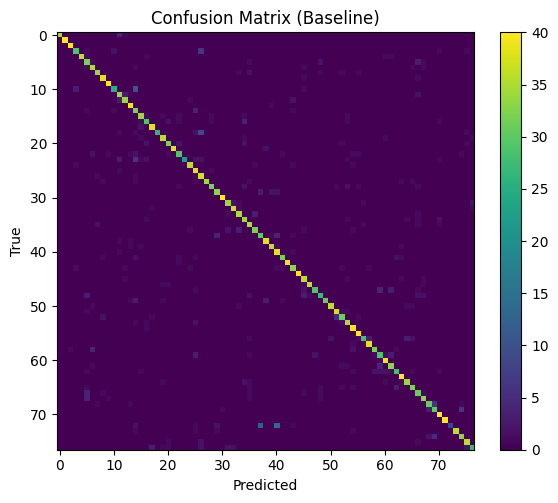

In [73]:

# Evaluación final en test (baseline vs BERT si está)
try:
    # BERT eval
    bert_logits = []
    import torch
    for b in range(0, len(tokenized["test"]), 64):
        batch = tokenized["test"][b:b+64]
        enc = tokenizer(batch["text"], return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            out = model(**enc).logits
        bert_logits.append(out.cpu().numpy())
    import numpy as np
    bert_logits = np.vstack(bert_logits)
    bert_preds = bert_logits.argmax(axis=1)
    bert_acc = accuracy_score(dataset["test"]["label"], bert_preds)
    bert_f1 = f1_score(dataset["test"]["label"], bert_preds, average="macro")
    print(f"BERT Test Accuracy: {bert_acc:.4f}  Macro-F1: {bert_f1:.4f}")
except Exception as e:
    print("BERT evaluación omitida:", e)

# Baseline eval (ya calculado). Reporte de clasificación sobre test:
print("\nBaseline (TF‑IDF + LR) - Classification report (test):")
print(classification_report(test_labels, test_pred, target_names=label_list, digits=4))

# Gráfico: matriz de confusión (baseline)
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()



## 12. Plataformas necesarias y notas de ejecución

- **Google Colab**: ejecutar este notebook (GPU opcional para BERT).
- **Hugging Face `datasets` y `transformers`** para NLU (Banking77 + BERT).
- **scikit‑learn** para baseline TF‑IDF + LogisticRegression.
- **FastAPI + Uvicorn + pyngrok** para exponer la **API** y obtener una URL pública temporal.
- **Gradio** para la **interfaz web**.
- **pytesseract** para OCR (pipeline multimodal).

> Para producción, considerar: endpoints en un servidor propio, almacenamiento de logs/feedback en DB, autenticación y monitoreo.


In [ ]:
!pip install pyngrok -q